In [1]:
using Clapeyron
using Plots
using CSV
using DataFrames
using LaTeXStrings
using Measures

In [2]:
model_mix = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1]),("Water",["H2O"=>1]),("Sulphur Dioxide",["SO2"=>1])];

        userlocations = (Mw = [16.02285, 14.02658, 31.03392, 18.01528, 64.066],

        epsilon = [284.78 348.39 528.21 339.89 453.85;
                   348.39 473.39 423.17 423.63 301.96;
                   528.21 423.17 407.22 358.02 302.89;
                   339.89 423.63 358.02 266.68 239.53;
                   453.85 301.96 302.89 239.53 237.54],
        sigma = [3.2477, 4.8801, 3.4054, 3.0063, 3.1605],
        lambda_a = [6, 6, 6, 6, 6],
        lambda_r = [10.354 14.063 52.305 13.085 12.412;
                    14.063 19.871 21.230 100.00 17.354;
                    52.305 21.230 22.699 19.619 18.511;
                    13.085 100.00 19.619 17.020 16.085;
                    12.412 17.354 18.511 16.085 15.213],
        vst = [1, 1, 2, 1, 3],
        S = [0.79675, 0.22932, 0.58538, 1, 0.62547],
        n_H=[2, 0, 1, 2, 1],
        n_e=[1, 0, 2, 2, 1],
        epsilon_assoc = Dict([(("NH2","H"),("NH2","e")) => 1070.80,
                              (("NH2","H"),("CH2OH","e")) => 629.88,
                              (("NH2","H"),("H2O","e")) => 1364.40,
                              (("NH2","H"),("SO2","e")) => 663.02,
                              (("CH2OH","H"),("NH2","e")) => 2403.78,
                              (("CH2OH","H"),("CH2OH","e")) => 2097.90,
                              (("CH2OH","H"),("H2O","e")) => 600.00,
                              (("CH2OH","H"),("SO2","e")) => 1415.90,
                              (("H2O","H"),("NH2","e")) => 1877.50,
                              (("H2O","H"),("CH2OH","e")) => 2000.60,
                              (("H2O","H"),("H2O","e")) => 1985.40,
                              (("H2O","H"),("SO2","e")) => 1343.90,
                              (("SO2","H"),("NH2","e")) => 663.02,
                              (("SO2","H"),("CH2OH","e")) => 1415.90,
                              (("SO2","H"),("H2O","e")) => 1343.90,
                              (("SO2","H"),("SO2","e")) => 955.58,
                             ]),
                    

        bondvol = Dict([(("NH2","H"),("NH2","e")) => 95.225e-30,
                        (("NH2","H"),("CH2OH","e")) => 346.08e-30,
                        (("NH2","H"),("H2O","e")) => 22.450e-30,
                        (("NH2","H"),("SO2","e")) => 345.890e-30,
                        (("CH2OH","H"),("NH2","e")) => 26.192e-30,
                        (("CH2OH","H"),("CH2OH","e")) => 62.309e-30,
                        (("CH2OH","H"),("H2O","e")) => 490.19e-30,
                        (("CH2OH","H"),("SO2","e")) => 303.270e-30,
                        (("H2O","H"),("NH2","e")) => 459.18e-30,
                        (("H2O","H"),("CH2OH","e")) => 130.02e-30,
                        (("H2O","H"),("H2O","e")) => 101.69e-30,
                        (("H2O","H"),("SO2","e")) => 353.41e-30,
                        (("SO2","H"),("NH2","e")) => 345.890e-30,
                        (("SO2","H"),("CH2OH","e")) => 303.270e-30,
                        (("SO2","H"),("H2O","e")) => 353.41e-30,
                        (("SO2","H"),("SO2","e")) => 849.99e-30,
                       ])));

In [3]:
wt_MEA = [0.1, 0.2, 0.3, 0.4, 0.5]
wt_H2O = 1 .- wt_MEA

mw_MEA = 61.08
mw_H2O = 18.01528

x_MEA = (wt_MEA ./ mw_MEA) .* (1 ./ ((wt_MEA ./ mw_MEA) .+ (wt_H2O ./ mw_H2O)))
x_H2O = 1 .- x_MEA
solvrat = x_H2O ./ x_MEA

5-element Vector{Float64}:
 30.514096922168292
 13.56182085429702
  7.911062165006595
  5.085682820361383
  3.3904552135742545

In [4]:
load = LinRange(0, 1, 100) #these are the ratio of SO2 mols to MEA mols in solution

N = length(load)

# intialise new composition vectors
x_MEA = zeros(N, 5)
x_H2O = zeros(N, 5)
x_SO2 = zeros(N, 5)
z = zeros(N, 15)

# calculate the new liquid compositions at these loadings
for i in 1:5
x_MEA[:,i] = 1 ./ (1 .+ load .+ solvrat[i])
x_SO2[:,i] = x_MEA[:,i] .* load
x_H2O[:,i] = 1 .- x_MEA[:,i] .- x_SO2[:,i]
ind = 3*(i-1) + 1
z[:, ind] = x_MEA[:,i]
z[:, ind + 1] = x_H2O[:,i]
z[:, ind + 2] = x_SO2[:,i]
end

In [5]:
T = [293, 313, 333]
waterfrac = zeros(N,3)
aminefrac = zeros(N,3)
waterspec = zeros(N,3)
aminespec = zeros(N,3)
actualamine = zeros(N,3)

for j in 1:3
        
    for i in 1:N
        x_bub = z[i, 7:9]
        calc = bubble_pressure(model_mix, T[j], x_bub)
        
        v = calc[2]
        X = Clapeyron.X(model_mix,v,T[j], x_bub)
        Δ = Clapeyron.Δ(model_mix,v,T[j], x_bub)
        ρwater = x_bub[2]*Clapeyron.N_A/v
        ρamine = x_bub[1]*Clapeyron.N_A/v
        nwater = model_mix.sites.n_sites[4][2]
        namine = model_mix.sites.n_sites[1][2]
        
        
        
        waterfrac[i,j] =  ρwater*nwater*Δ[2,3][2,1]*X[3][1]*X[2][2]
        aminefrac[i,j] =  ρamine*namine*Δ[1,3][2,1]*X[3][1]*X[1][2]
        waterspec[i,j] = waterfrac[i,j]*x_bub[3]
        aminespec[i,j] = aminefrac[i,j]*x_bub[3]
        actualamine[i,j] = waterfrac[i,j]*aminefrac[i,j]*x_bub[3]
    end
end



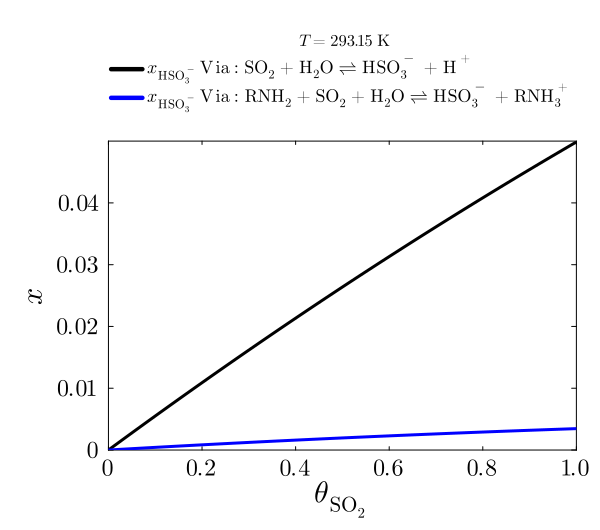

In [12]:
#waterspec = waterspec[2:100,:]
#actualamine = actualamine[2:100,:]

plt6 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T = 293.15 \ \mathrm{K}",
      xticks = ([0, 0.2, 0.4, 0.6, 0.8, 1.0],[L"0", L"0.2",L"0.4",L"0.6",L"0.8",L"1.0"]),
      xtickfont = font(16),
      yticks = ([0, 0.01, 0.02, 0.03, 0.04],[L"0", L"0.01",L"0.02",L"0.03",L"0.04"]),
      ytickfont = font(16),
      
      xlims = (0, 1),
      ylims = (0, 0.05),
      legend =:outertop,
      legend_background_color=:transparent,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=20,
      yguidefontsize=20,
    size = (600, 530)
)

# SO2(aq)+H2O⇋HSO􀀀
# 3 +H+

plot!(plt6, load, waterspec[:,1], 
      color = "black", 
      line = (:path, 3), 
      label = L"x_{\mathrm{HSO_3^-}} \mathrm{Via: SO_2 + H_2O \rightleftharpoons HSO_3^- + H^+}")


 plot!(plt6, load, actualamine[:,1], 
       color = "blue", 
       line = (:path, 3), 
       label = L"x_{\mathrm{HSO_3^-}} \mathrm{Via: RNH_2 + SO_2 + H_2O \rightleftharpoons HSO_3^- + RNH_3^+}")


  # plot!(plt6, load, aminespec[:,1], 
  #    color = "black", 
  #      line = (:dash, 3), 
  #      label = L"x_{\mathrm{NHCOO}^-} \mathrm{ without \ H_{2}O-CO_{2}}")

# plot!(plt6, loadfil, xHCO3_313_no_assoc, 
#       color = "blue", 
#       line = (:dash, 3), 
#       label = L"x_{\mathrm{HCO}_3^-} \mathrm{ without \ H_{2}O-CO_{2}}")

xlabel!(plt6, L"\theta_{\mathrm{SO_2}}")
ylabel!(plt6, L"x")

#savefig(plt6, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\SO_2 Speciation_title")

# df = DataFrame(
#     CO2_Loading = loadfil,  
#     xNHCOO_with_assoc = xNHCOO_313_assoc, 
#     xNHCOO_without_assoc = xNHCOO_313_no_assoc, 
#     xHCO3_with_assoc = xHCO3_313_assoc, 
#     xHCO3_without_assoc = xHCO3_313_no_assoc, 
# )
# CSV.write("Speciation_313.csv", df)